In [34]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
import sklearn, sklearn.metrics

import modutils

data_dir = '../DataSets/Churn/'
logm_fmt = data_dir + 'user_logs/uldtm_{0}.csv'
used_log = '201701'

In [40]:
src0 = pd.read_csv(logm_fmt.format(used_log))

In [41]:
features = ['used', 'ln_tot', 'ln_sec', 'pct_low', 'pct_100', 'pct_unq', 'avg_sec_n']
target = ['nxt_used']
devX = src0[src0.date < 20170131][features].values.reshape(-1, 30, len(features))
devY = src0.nxt_used[src0.date < 20170131].values.reshape(-1, 30)

In [45]:
(trainX, trainY), (validX, validY), (testX, testY) = modutils.splitSample((devX, devY), pcts=[0.2, 0.2, 0.6])

In [67]:
SEQ_LENGTH = 30
SEQ_FEATURES = len(features)
RNN_SIZE = [128]
HIDDEN_LAYER = 10

RCell = lambda n: tf.nn.rnn_cell.GRUCell(num_units=n, activation=tf.nn.elu)

tf.reset_default_graph()

rnnCell = tf.nn.rnn_cell.MultiRNNCell([RCell(s) for s in RNN_SIZE], state_is_tuple=True)

with tf.name_scope(name='INPUT'):
    tfi_x = tf.placeholder(shape=(None, SEQ_LENGTH, SEQ_FEATURES), dtype=tf.float32)
    tfi_y = tf.placeholder(shape=(None, SEQ_LENGTH), dtype=tf.int32)
    
    tfX = tfi_x
    tfY = tf.one_hot(tfi_y, 2, dtype=tf.float32)
    tfActual = tf.cast(tfi_y, dtype=tf.float32)

with tf.name_scope(name='RNN'):
    tfRNN_Hist, _ = tf.nn.dynamic_rnn(rnnCell, inputs=tfX, dtype=tf.float32, time_major=False)
    
    tfRNN_HistHid = tf.layers.dense(tfRNN_Hist, HIDDEN_LAYER, activation=tf.nn.elu)
    tfRNN_HistRes = tf.layers.dense(tfRNN_HistHid, 2)

with tf.name_scope(name='LOSS'):
    tfLoss0 = tf.nn.softmax_cross_entropy_with_logits(labels=tfY[:,10:,:], logits=tfRNN_HistRes[:,10:,:])
    tfLoss = tf.reduce_mean(tfLoss0)
    tfTrain = tf.train.AdamOptimizer(1e-3).minimize(tfLoss)

with tf.name_scope(name='OUTPUT'):
    #tfPredicted = tf.argmax(tfRNN_HistRes, axis=2)
    tfProbability = tf.nn.softmax(tfRNN_HistRes)[:,:,1]
    tfLogOdds = tf.log(tfProbability / (1-tfProbability))

tfsLoss = tf.summary.scalar('CrossEntropy', tfLoss)

tffw = tf.summary.FileWriter('D:/Jupyter/Logs/00_A', tf.get_default_graph())
print('Graph creation complete')

Graph creation complete


In [68]:
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tffw = tf.summary.FileWriter('D:/Jupyter/Logs/19CHURN04-RNN-{0}'.format(dt_now), tf.get_default_graph())

batch_size = 500
num_steps  = 2
num_epochs = 100
checkpoints = 10 #every %x% epochs save the model

fmtstr = 'Epoch {0} ({1:1.3} sec): \t\tVL:{2:1.3f}\t\tGINI:{3:1.3f}'
valid_batch = {tfi_x: validX, tfi_y: validY}
valid_p = None
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        te0 = time.perf_counter()
        counter0 = 0
        num0 = trainY.shape[0] // batch_size
        if num0 * batch_size < trainY.shape[0]:
            num0 += 1
        for (mini_x, mini_y) in modutils.shuffleBatches((trainX, trainY), batchSize=batch_size):
            train_batch = {tfi_x:mini_x, tfi_y: mini_y}
            
            l0 = tfLoss.eval(feed_dict=train_batch)
            t0 = time.perf_counter()
            for j in range(num_steps):
                tfTrain.run(feed_dict=train_batch)
            t1 = time.perf_counter()
            l1 = tfLoss.eval(feed_dict=train_batch)
            counter0 += 1
            print('Train-step {3}/{4}: {0:.3f}->{1:.3f} in {2:.2f} sec'.format(l0, l1, t1-t0, counter0, num0), end='\r')
    
        te1 = time.perf_counter()
        lv = tfLoss.eval(feed_dict=valid_batch)
        valid_p = tfProbability.eval(feed_dict=valid_batch)
        gn = sklearn.metrics.roc_auc_score(validY[:,-1], valid_p[:,-1]) * 2 -1
        if i%checkpoints == 0 and i > 0:
            p = tfsSaver.save(tfs, 'D:/Jupyter/mltest/Models-13RNN02/model-{0:02d}.ckpt'.format(i))
            print('Model saved at checkpoint: {0}'.format(p))
                             
        print(fmtstr.format(i,te1-te0,lv,gn))
    #valid_r = tfs.run(tfOutR, feed_dict=valid_batch)

Epoch 0 (3.3e+02 sec): 		VL:0.445		GINI:0.727
Epoch 1 (3.42e+02 sec): 		VL:0.443		GINI:0.738
Epoch 2 (3.6e+02 sec): 		VL:0.441		GINI:0.741
Epoch 3 (3.25e+02 sec): 		VL:0.441		GINI:0.742


KeyboardInterrupt: 

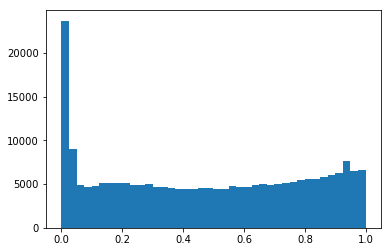

In [66]:
plt.hist(valid_p[:,29], bins=40)
plt.show()

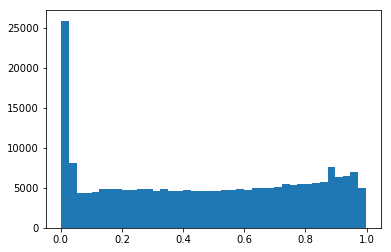

In [69]:
plt.hist(valid_p[:,29], bins=40)
plt.show()

In [71]:
valid_pl = valid_p[:,29]
valid_yl = validY[:,29]

0.031935514372163389